<a href="https://colab.research.google.com/github/NateshReddy/Denoising-Algorithm-Implementation-/blob/master/cifar10_denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A denoising autoencoder for CIFAR10 dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10

In [9]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()

In [10]:
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

#### We have produced a noisy data. To do this we added gaussian noise with mean=0 and std=0.1 and then clip values back to 0-1. Mean=0 noise makes some parts of the image darker and some lighter after addition.

In [11]:
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data
train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

In [12]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.figtext(0.5,0.5, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.subplots_adjust(hspace = 0.3 )
    plt.show()

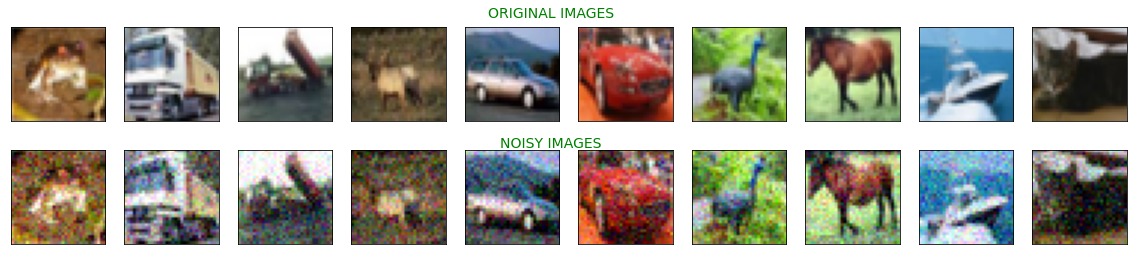

In [13]:
showOrigDec(train_data_clean, train_data_noisy)

Now we define the building blocks of our DAE: a convolutional block and a deconvolutional block.

Convolutional blocks consist of 3 operations: 2D convolution, batch normalization and ReLu activation. We use strides=2 to downsample data going through the network.

Deconvolutional blocks also consist of 3 operations: 2D transposed convolution, batch normalization and also ReLu activation. Here strides=2 is used to upsample the data.

In [14]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

Our model architecture consist of:

1. 4 convolutional blocks with downsampling
1. 1 convolutional block without downsampling
1. 4 deconvolutional blocks with upsampling, interleaving concatenations
1. 1 final deconvolution that recreates image size (32, 32, 3)
1. 1 activation layer with sigmoid that scales values to 0-1.

In [15]:
def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)

   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block4)

   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
  
   return Model(dae_inputs, dae_outputs, name='dae')

Now we compile the model using mean squared error as our loss and Adam as the optimizer. ModelCheckpoint callback saves currently the best model during training.

And finally we train the model for 40 epochs. Using batch_size=128.

In [16]:
dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae.fit(train_data_noisy,
       train_data_clean,
       validation_data=(test_data_noisy, test_data_clean),
       epochs=40,
       batch_size=128,
       callbacks=[checkpoint])

Epoch 1/40
391/391 [==============================] - ETA: 0s - loss: 0.0046
Epoch 00001: val_loss improved from inf to 0.00610, saving model to best_model.h5
391/391 [==============================] - 9s 23ms/step - loss: 0.0046 - val_loss: 0.0061
Epoch 2/40
391/391 [==============================] - ETA: 0s - loss: 0.0025
Epoch 00002: val_loss improved from 0.00610 to 0.00275, saving model to best_model.h5
391/391 [==============================] - 8s 21ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 3/40
391/391 [==============================] - ETA: 0s - loss: 0.0022
Epoch 00003: val_loss improved from 0.00275 to 0.00226, saving model to best_model.h5
391/391 [==============================] - 8s 22ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 4/40
391/391 [==============================] - ETA: 0s - loss: 0.0022
Epoch 00004: val_loss improved from 0.00226 to 0.00197, saving model to best_model.h5
391/391 [==============================] - 8s 22ms/step - loss: 0.0022 - val_loss:

Now we load our best model weights and try to predict (denoise) our CIFAR10 test data to visualize how well our DAE performs. 

In [17]:
dae.save('/content/drive/My Drive/denoising task/model1/model1.h5')
del dae

In [18]:
dae = load_model('/content/drive/My Drive/denoising task/model1/model1.h5')
test_data_denoised = dae.predict(test_data_noisy)

In [24]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.figtext(0.5,0.65, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.figtext(0.5,0.35, " DENOISED RECONSTRUCTED IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.subplots_adjust(hspace = 0.5 )
    plt.show()

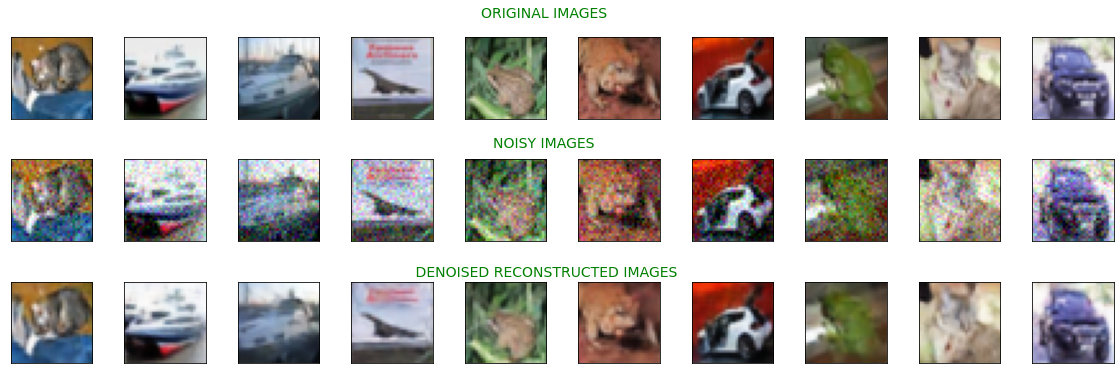

In [25]:
showOrigDec(test_data_clean, test_data_noisy, test_data_denoised)

Now we will calculate the mean squared error of the whole CIFAR10 test set. First we will calculate the mse between our clean data and the data with added noise. Next we check how well our DAE denoised the data.

In [ ]:
def mse(data_1, data_2):
   return np.square(np.subtract(data_1, data_2)).mean()

noisy_clean_mse = mse(test_data_clean, test_data_noisy)
denoised_clean_mse = mse(test_data_denoised, test_data_clean)

noisy_clean_mse, denoised_clean_mse

(0.009111093195190167, 0.0015426716)

As you can see, our DAE decreased the noise around 6x (by ~83%).